<a href="https://colab.research.google.com/github/Mutasar/Klasifikasi-Gambar/blob/main/template_submission_akhir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [Fruit Classification Dataset]
**Nama:** [Mutasar]

**Email:** [mutasarstmik@gmail.com]

**ID Dicoding:** [l319ywd083]

## Import Semua Packages/Library yang Digunakan

In [10]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

## Data Preparation

### Data Loading

In [11]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"mutasar","key":"a9ebddb49d3274408fbb52fdb9dcdbee"}'}

In [13]:
import kagglehub
moltean_fruits_path = kagglehub.dataset_download('moltean/fruits')

print('Data source import complete.')

Data source import complete.


In [14]:
# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fruits


In [15]:
train_dir = r"/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training"
test_dir = r"/kaggle/input/fruits/fruits-360_100x100/fruits-360/Test"

In [23]:
# Memuat tabel day
df = pd.read_csv("https://raw.githubusercontent.com/Mutasar/Klasifikasi-Gambar/refs/heads/main/file.csv")
display(df)


,image_path,class,split
0,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train
1,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train
2,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train
3,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train
4,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train
...,...,...,...
138699,/kaggle/input/fruits/fruits-360_100x100/fruits...,Pineapple 1,test
138700,/kaggle/input/fruits/fruits-360_100x100/fruits...,Pineapple 1,test
138701,/kaggle/input/fruits/fruits-360_100x100/fruits...,Pineapple 1,test
138702,/kaggle/input/fruits/fruits-360_100x100/fruits...,Pineapple 1,test


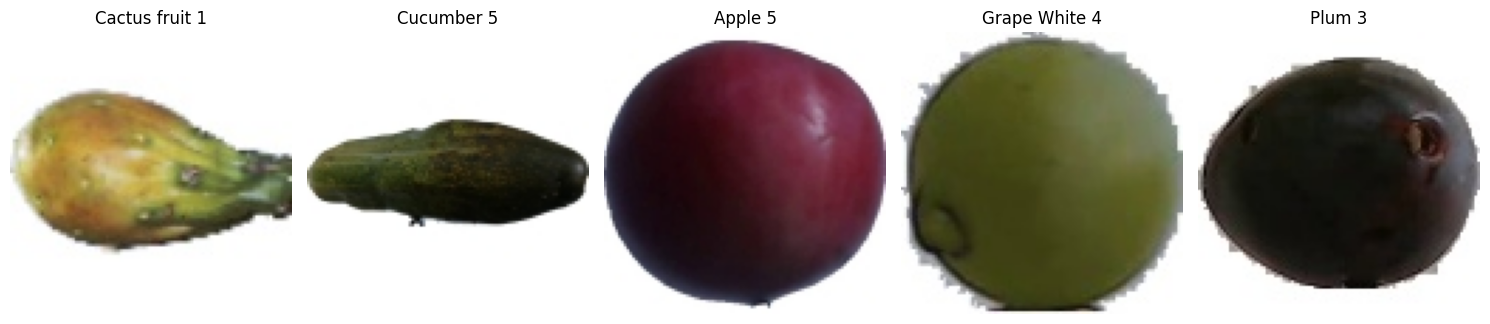

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

# Assuming df DataFrame is available and has an 'image_path' column
if 'df' in locals() and not df.empty:
    # Select a few random image paths
    num_images_to_display = 5
    if len(df) < num_images_to_display:
        num_images_to_display = len(df_images)

    random_image_paths = random.sample(df_images['image_path'].tolist(), num_images_to_display)

    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(random_image_paths):
        try:
            img = mpimg.imread(image_path)
            plt.subplot(1, num_images_to_display, i + 1)
            plt.imshow(img)
            plt.title(os.path.basename(os.path.dirname(image_path))) # Display class name as title
            plt.axis('off')
        except FileNotFoundError:
            print(f"Error: Image file not found at {image_path}")
        except Exception as e:
            print(f"Error displaying image {image_path}: {e}")

    plt.tight_layout()
    plt.show()
else:
    print("DataFrame 'df_images' not found or is empty. Please ensure the cell that creates df_images has been run.")

In [31]:
if 'df_images' in locals() and not df_images.empty:
    total_images = len(df_images)
    print(f"Total number of images in the dataset: {total_images}")
else:
    print("DataFrame 'df_images' not found or is empty. Please ensure the cell that creates df_images has been run.")

Total number of images in the dataset: 138704


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138704 entries, 0 to 138703
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_path  138704 non-null  object
 1   class       138704 non-null  object
 2   split       138704 non-null  object
dtypes: object(3)
memory usage: 3.2+ MB


### Cleaning Data

In [29]:
train_classes = sorted(os.listdir(train_dir))
test_classes = sorted(os.listdir(test_dir))

missing_in_test = set(train_classes) - set(test_classes)

print(f"Jumlah kelas di train_dir : {len(train_classes)}")
print(f"Jumlah kelas di test_dir  : {len(test_classes)}\n")

if missing_in_test:
    print("Kelas yang hilang di test_dir:")
    for cls in sorted(missing_in_test):
        print(f"- {cls}")
else:
    print("Semua kelas di train_dir juga ada di test_dir ✅")

Jumlah kelas di train_dir : 206
Jumlah kelas di test_dir  : 206

Semua kelas di train_dir juga ada di test_dir ✅


In [32]:
# Impute numerical exif columns with median
numerical_exif_cols = ['exif_iso'] # Based on previous dtypes output, only 'exif_iso' is numerical among exif
for col in numerical_exif_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Impute object exif columns with 'Unknown'
object_exif_cols = ['exif_camera_make', 'exif_camera_model', 'exif_aperture_value', 'exif_focal_length', 'exif_exposure_time']
for col in object_exif_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

print(df.isnull().sum())

image_path    0
class         0
split         0
dtype: int64


In [34]:
# Impute remaining object type columns with 'Unknown'
object_cols_with_nulls = ['ai_description', 'blur_hash']
for col in object_cols_with_nulls:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

print(df.isnull().sum())

image_path    0
class         0
split         0
dtype: int64


In [35]:
display(df.head())
df.info()

,image_path,class,split
0,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train
1,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train
2,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train
3,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train
4,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138704 entries, 0 to 138703
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_path  138704 non-null  object
 1   class       138704 non-null  object
 2   split       138704 non-null  object
dtypes: object(3)
memory usage: 3.2+ MB


### Data Preprocessing

#### Split Dataset

In [36]:
from sklearn.model_selection import train_test_split

# Assuming 'photo_id' is the unique identifier and there is a target variable (replace 'target_column' with your actual target column)
# If you don't have a target column yet, the split will be purely random.
# If you have a target column and want stratified split, uncomment the 'stratify' parameter.

# First split: 85% for training+validation, 15% for test
df_train_val, df_test = train_test_split(df, test_size=0.15, random_state=42) # stratify=df['target_column'] if applicable

# Second split: Split the training+validation set into 70% training and 15% validation (from original data size)
test_size_proportion = 0.15 / (1 - 0.15) # Calculate the proportion of the train_val set to use for validation
df_train, df_val = train_test_split(df_train_val, test_size=test_size_proportion, random_state=42) # stratify=df_train_val['target_column'] if applicable

print("Training set shape:", df_train.shape)
print("Validation set shape:", df_val.shape)
print("Test set shape:", df_test.shape)

Training set shape: (97092, 3)
Validation set shape: (20806, 3)
Test set shape: (20806, 3)


## Modelling

In [38]:
from tensorflow.keras.layers import Input

# Get the number of unique classes from the df_images DataFrame
if 'df_images' in locals() and not df_images.empty:
    num_classes = df_images['class'].nunique()
    print(f"Number of classes: {num_classes}")
else:
    print("Error: df_images DataFrame not found or is empty. Cannot determine the number of classes.")
    num_classes = None # Set to None or a default value if df_images is not available


# Example of a simple Sequential CNN model
if num_classes is not None:
    simple_sequential_model = Sequential([
        # Input Layer
        Input(shape=(224, 224, 3)),
        # Convolutional Layer 1
        Conv2D(32, (3, 3), activation='relu'),
        # Pooling Layer 1
        MaxPooling2D((2, 2)),

        # Convolutional Layer 2
        Conv2D(64, (3, 3), activation='relu'),
        # Pooling Layer 2
        MaxPooling2D((2, 2)),

        # Convolutional Layer 3
        Conv2D(128, (3, 3), activation='relu'),
        # Pooling Layer 3
        MaxPooling2D((2, 2)),

        # Flatten the output for the dense layers
        Flatten(),

        # Dense Layer 1
        Dense(128, activation='relu'),
        # Dropout for regularization (optional)
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax') # Use the defined num_classes
    ])

    # Print the model summary to see the layers
    simple_sequential_model.summary()

    print("\nThis is an example of a Sequential CNN built from scratch.")
    print("In your main project, we are using a Sequential model on top of a pre-trained MobileNetV2 base in cell 719c697a.")
else:
    print("\nModel could not be built due to missing num_classes.")

Number of classes: 206


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 206)            │        26,574 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,195,534 (42.71 MB)

 Trainable params: 11,195,534 (42.71 MB)

 Non-trainable params: 0 (0.00 B)


This is an example of a Sequential CNN built from scratch.
In your main project, we are using a Sequential model on top of a pre-trained MobileNetV2 base in cell 719c697a.


In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Define image size
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

# Assuming train_dir and test_dir are defined from earlier cells (e.g., cell i9h_BhFTgkpP)
# train_dir = r"/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training"
# test_dir = r"/kaggle/input/fruits/fruits-360_100x100/fruits-360/Test"

# Data Augmentation and Rescaling for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2, # Randomly shift images vertically
    shear_range=0.2,        # Apply shear transformation
    zoom_range=0.2,         # Apply random zoom
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill mode for newly created pixels
)

# Rescaling for Validation and Test Data (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255) # Only normalize for validation/test

# Create data generators
print("Creating data generators...")

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical' # Use 'categorical' for multi-class classification
)

# Validation generator
# We will split the training data for validation.
# Alternatively, if you have a separate validation directory, use that.
# For this dataset, we'll use a split from the training data for validation as no explicit validation folder is provided.
# Let's use the train_test_split results (df_train, df_val) to guide this,
# but ImageDataGenerator.flow_from_directory directly uses the directory structure.
# A common approach is to use validation_split in ImageDataGenerator, but it works on the directory structure itself, not pre-split dataframes.
# Given we already have df_train and df_val, we can use flow_from_dataframe instead.

# Let's switch to flow_from_dataframe since we have df_train and df_val
print("Creating data generators from DataFrames...")

train_datagen_df = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen_df = ImageDataGenerator(rescale=1./255)

train_generator_df = train_datagen_df.flow_from_dataframe(
    dataframe=df_train, # Use the training split DataFrame
    x_col='image_path',  # Column with image paths
    y_col='class',       # Column with class labels
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Multi-class classification
    subset=None # Use the entire df_train for training
)

val_generator_df = val_test_datagen_df.flow_from_dataframe(
    dataframe=df_val, # Use the validation split DataFrame
    x_col='image_path',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset=None # Use the entire df_val for validation
)

test_generator_df = val_test_datagen_df.flow_from_dataframe(
    dataframe=df_test, # Use the test split DataFrame
    x_col='image_path',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset=None # Use the entire df_test for testing
)

print("\nData generators created successfully using flow_from_dataframe.")
print(f"Number of training samples: {train_generator_df.samples}")
print(f"Number of validation samples: {val_generator_df.samples}")
print(f"Number of test samples: {test_generator_df.samples}")
print(f"Number of classes: {len(train_generator_df.class_indices)}") # Corrected line
print(f"Class indices: {train_generator_df.class_indices}")

# You can now use train_generator_df, val_generator_df, and test_generator_df for model training and evaluation.
# Note: The variable names are suffixed with _df to distinguish from the flow_from_directory attempt.
# In your training steps, use these new generator variables.

Creating data generators...
Found 103993 images belonging to 206 classes.
Creating data generators from DataFrames...
Found 97092 validated image filenames belonging to 206 classes.
Found 20806 validated image filenames belonging to 206 classes.
Found 20806 validated image filenames belonging to 206 classes.

Data generators created successfully using flow_from_dataframe.
Number of training samples: 97092
Number of validation samples: 20806
Number of test samples: 20806
Number of classes: 206
Class indices: {'Apple 10': 0, 'Apple 11': 1, 'Apple 12': 2, 'Apple 13': 3, 'Apple 14': 4, 'Apple 17': 5, 'Apple 18': 6, 'Apple 19': 7, 'Apple 5': 8, 'Apple 6': 9, 'Apple 7': 10, 'Apple 8': 11, 'Apple 9': 12, 'Apple Braeburn 1': 13, 'Apple Core 1': 14, 'Apple Crimson Snow 1': 15, 'Apple Golden 1': 16, 'Apple Golden 2': 17, 'Apple Golden 3': 18, 'Apple Granny Smith 1': 19, 'Apple Pink Lady 1': 20, 'Apple Red 1': 21, 'Apple Red 2': 22, 'Apple Red 3': 23, 'Apple Red Delicious 1': 24, 'Apple Red Yello

In [45]:
import os
import shutil

# Define the path for the combined directory
# You can change './combined_dataset' to your desired location
combined_dir = './combined_dataset'

# Create the combined directory if it doesn't exist
os.makedirs(combined_dir, exist_ok=True)

# Assuming train_dir and test_dir are defined from earlier cells (e.g., cell i9h_BhFTgkpP)
# train_dir = r"/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training"
# test_dir = r"/kaggle/input/fruits/fruits-360_100x100/fruits-360/Test"

# Salin file dan folder dari train
print(f"Copying files from {train_dir} to {combined_dir}...")
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)
print("Finished copying training data.")

# Salin file dan folder dari test
print(f"Copying files from {test_dir} to {combined_dir}...")
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)
print("Finished copying test data.")

print("\nCombined dataset created successfully.")

Copying files from /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training to ./combined_dataset...
Finished copying training data.
Copying files from /kaggle/input/fruits/fruits-360_100x100/fruits-360/Test to ./combined_dataset...
Finished copying test data.

Combined dataset created successfully.


##Checking Data

In [55]:
# Check the number of images per class
if 'df_images' in locals() and not df_images.empty:
    print("Number of images per class:")
    display(df_images['class'].value_counts().head()) # Displaying head as there are many classes

    # Check the distribution across splits
    print("\nDistribution of images across splits:")
    display(df_images['split'].value_counts())

    # Check distribution of classes within each split
    print("\nDistribution of classes within each split:")
    display(pd.crosstab(df_images['split'], df_images['class']).head()) # Displaying head for brevity
else:
    print("DataFrame 'df_images' not found or is empty. Please ensure the cell that creates df_images has been run.")

Number of images per class:


,count
class,
Grape Blue 1,1312
Cherimoya 1,1292
Plum 3,1204
Quince 4,999
Tomato 1,984



Distribution of images across splits:


,count
split,
train,103993
test,34711



Distribution of classes within each split:


class,Apple 10,Apple 11,Apple 12,Apple 13,Apple 14,Apple 17,Apple 18,Apple 19,Apple 5,Apple 6,...,Tomato Cherry Yellow 1,Tomato Heart 1,Tomato Maroon 1,Tomato Maroon 2,Tomato Yellow 1,Tomato not Ripen 1,Walnut 1,Watermelon 1,Zucchini 1,Zucchini dark 1
split,,,,,,,,,,,,,,,,,,,,,
test,231,142,154,235,154,201,160,241,146,157,...,100,228,127,147,153,158,249,157,80,80
train,699,430,466,699,466,610,484,729,440,473,...,303,684,367,445,459,474,735,475,240,240


## Evaluasi dan Visualisasi

## Konversi Model

## Inference (Optional)

In [3]:
# Start training the model
# Make sure you have defined the actual number of classes and compiled the model before running this cell.
# Remember to refine the label preparation in the data pipeline (cell 4be73d1f) for your specific multi-label task.

EPOCHS = 10 # You can adjust the number of training epochs

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)

print("Model training complete.")

NameError: name 'model' is not defined

In [2]:
!pip install kagglehub

In [20]:
import os
import pandas as pd

# Assuming your train and test directories are defined as follows:
# (These variables were defined in cell i9h_BhFTgkpP)
# train_dir = r"/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training"
# test_dir = r"/kaggle/input/fruits/fruits-360_100x100/fruits-360/Test"

# Check if the directories exist
if not os.path.exists(train_dir):
    print(f"Error: Training directory not found at {train_dir}")
elif not os.path.exists(test_dir):
    print(f"Error: Test directory not found at {test_dir}")
else:
    print(f"Processing images from: {train_dir} and {test_dir}")

    data = []

    # Process training data
    print("Processing training data...")
    for class_name in os.listdir(train_dir):
        class_dir = os.path.join(train_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                if os.path.isfile(image_path):
                    data.append({'image_path': image_path, 'class': class_name, 'split': 'train'})

    # Process test data
    print("Processing test data...")
    for class_name in os.listdir(test_dir):
        class_dir = os.path.join(test_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                if os.path.isfile(image_path):
                    data.append({'image_path': image_path, 'class': class_name, 'split': 'test'})

    # Create a pandas DataFrame
    df_images = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    csv_output_path = './fruit_images_data.csv' # You can change the filename
    df_images.to_csv(csv_output_path, index=False)

    print(f"\nSuccessfully created CSV file at: {csv_output_path}")
    display(df_images.head())
    df_images.info()

Processing images from: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training and /kaggle/input/fruits/fruits-360_100x100/fruits-360/Test
Processing training data...
Processing test data...

Successfully created CSV file at: ./fruit_images_data.csv


,image_path,class,split
0,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train
1,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train
2,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train
3,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train
4,/kaggle/input/fruits/fruits-360_100x100/fruits...,Melon Piel de Sapo 1,train


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138704 entries, 0 to 138703
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_path  138704 non-null  object
 1   class       138704 non-null  object
 2   split       138704 non-null  object
dtypes: object(3)
memory usage: 3.2+ MB


In [21]:
# Assuming you want to save the df_images DataFrame to a CSV file
# If you want to save a different DataFrame, please specify its name.

csv_output_path = 'file.csv' # The desired filename

try:
    df_images.to_csv(csv_output_path, index=False)
    print(f"Successfully saved df_images to {csv_output_path}")
    # You can then download this file from the Colab file browser
except NameError:
    print("Error: DataFrame 'df_images' not found. Please ensure the cell that creates df_images has been run.")
except Exception as e:
    print(f"An error occurred while saving the CSV: {e}")

Successfully saved df_images to file.csv


In [22]:
files.download('file.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
# Assuming your compiled and trained model is named 'model' or 'simple_sequential_model'
# If your model has a different name, please replace 'model' with the correct variable name.

# Choose which model to evaluate (e.g., the simple sequential model)
# If you plan to use a different model later, update this variable accordingly.
model_to_evaluate = simple_sequential_model # Or your actual trained model variable

if 'model_to_evaluate' in locals() and model_to_evaluate is not None:
    print("Evaluating the model on the test set...")

    # Evaluate the model
    # The evaluate method returns the loss value and metrics values for the model in test mode.
    # The metrics returned depend on what was specified during model compilation.
    evaluation_results = model_to_evaluate.evaluate(test_generator_df)

    # Display the evaluation results
    print("\nTest Evaluation Results:")
    for name, value in zip(model_to_evaluate.metrics_names, evaluation_results):
        print(f"{name}: {value}")
else:
    print("Error: No compiled and trained model found to evaluate. Please ensure your model is defined, compiled, and trained.")

Evaluating the model on the test set...


ValueError: You must call `compile()` before using the model.

In [43]:
# Compile the model
# Assuming your model is named 'simple_sequential_model'
# If using a different model, replace 'simple_sequential_model' with its name.

if 'simple_sequential_model' in locals() and simple_sequential_model is not None:
    print("Compiling the model...")
    simple_sequential_model.compile(
        optimizer='adam',  # Or choose another optimizer like 'rmsprop' or 'sgd'
        loss='categorical_crossentropy', # Suitable for multi-class classification
        metrics=['accuracy'] # To track accuracy during training and evaluation
    )
    print("Model compiled successfully.")
else:
    print("Error: Model 'simple_sequential_model' not found. Please ensure the model is defined before compiling.")

Compiling the model...
Model compiled successfully.
